# Nonlinear Eulerian elasticity using the inverse map

**Description:** This is a collection of nonlinear PDEs for Lagrangian/Eulerian hyperelastic solids and ultimately for a two-phase model describing the travelling porosity wave phenomenon. 

**Authors:** Andrea Zafferi, Dirk Peschka

## 1. Darcy-type dissipation

### Lagrangian formulation

...

###  Eulerian formulation

...


### CODE BLOCK 3: Basic definitions for Darcy solver

Description: 

In [78]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt 

import logging
from utils import *

logging.getLogger('FFC').setLevel(logging.WARNING)
parameters["form_compiler"]["quadrature_degree"] = 5

# ------------------------------------
# Lagrangian energy
# ------------------------------------
def energybar(qbar):
    xbar = SpatialCoordinate(meshbar)
    I    = Identity(dim)
    Fbar = I + grad(qbar)
    Cbar = Fbar.T*Fbar
    Jbar = det(Fbar)
    Ebar = mu/2*(tr(Cbar-I) - 2*ln(Jbar)) + lmbda/2*(Jbar-1)**2 + inner(f,xbar+qbar)
    return Ebar

# ------------------------------------
# Solve Lagrangian problem
# ------------------------------------
def evolve_bar(old_ubar,tau):
    ubar  = Function(Qbar)     # unknown 
    dubar = TestFunction(Qbar) # test function
    
    I     = Identity(dim)
    old_F = I + grad(old_ubar)
    old_J = det(old_F)
    
    Hbar     = energybar(ubar)*dx
    dot_ubar = (ubar - old_ubar) / tau
    
    Resbar  = derivative(Hbar,ubar,dubar)
    Resbar += kappa*inner(dot_ubar, dubar)*old_J*dx
    
    ubar.assign(old_ubar)
    solve(Resbar==0,ubar,bcbar,solver_parameters={'newton_solver': {'linear_solver': 'mumps'}})
    return ubar 

# ------------------------------------
# Eulerian energy
# ------------------------------------
def energy(q):
    x = SpatialCoordinate(mesh)
    I = Identity(dim)
    F = inv(I - grad(q))
    C = F.T*F
    J = det(F)
    E = ( mu/2*(tr(C-I) - 2*ln(J)) + lmbda/2*(J-1)**2 + inner(f,x) ) / J
    return E

# ------------------------------------
# Solve Eulerian problem
# ------------------------------------
def evolve(old_u,tau):
    u     = Function(Q)     # unknown 
    du    = TestFunction(Q) # test function
    
    I     = Identity(dim)
    F     = inv(I - grad(u))
    old_F = inv(I - grad(old_u))
    
    H      = energy(u)*dx
    dot_u  = (u - old_u) / tau
    
    Res  = derivative(H,u,du)
    Res += kappa*inner(old_F*dot_u, old_F*du)*dx
    
    u.assign(old_u)
    solve(Res==0,u,bc,solver_parameters={'newton_solver': {'linear_solver': 'mumps'}})
    return u

# ------------------------------------
# Setup model parameters
# ------------------------------------

k           = 256   # mesh points
mu          = 1.0   # Lame constant
lmbda       = 2.0   # Lame constant
f0          = 6.0   # gravity
kappa       = 0.5

for rr in range(7):
    #n_steps  = 256
    #k        = 4*(2**rr)
    
    n_steps  = 4 * 2**rr
    k        = 256

    T        = 0.05
    tau      = T/n_steps
    
    print('tau:',tau,' n_steps:',n_steps,' k:',k)
    
    dim         = 2     # spatial dimension
    FE_deg      = 1
    FE          = VectorElement('P',triangle,FE_deg)
    NEWTON_tol  = 1e-10
    
    # ------------------------------------
    # Setup Lagrangian/Eulerian mesh, function space, Dirichlet bcs
    # ------------------------------------
    
    meshbar     = UnitSquareMesh(k,k) # Generation of Lagrangian mesh
    mesh        = UnitSquareMesh(k,k) # Generation of Eulerian mesh
        
    Qbar  = get_space(meshbar,FE)   # Lagrangian state space 
    Q     = get_space(mesh   ,FE)   # Eulerian state space
    
    
    bcbar = DirichletBC(Qbar, Constant((0, 0)) , 'on_boundary')
    bc    = DirichletBC(Q   , Constant((0, 0)) , 'on_boundary')
    f     = Expression(('0','f0'),f0=f0,degree=2)
    
    
    init     = Expression(('0','0'),degree=2)
    old_ubar = interpolate(init,Qbar)
    t        = 0.0
    write_state(meshbar,old_ubar,'output_darcy/statebarP1_'+str(k)+'_'+str(n_steps)+'_'+str(0),0,t)
    for i in range(n_steps):
        print("0:",i)
        ubar = evolve_bar(old_ubar,tau)
        old_ubar.assign(ubar)
        t += tau
        write_state(meshbar,old_ubar,'output_darcy/statebarP1_'+str(k)+'_'+str(n_steps)+'_'+str(i+1),i+1,t)
        
        
    old_u    = interpolate(init,Q)
    t        = 0.0
    write_state(mesh,old_u,'output_darcy/stateP1_'+str(k)+'_'+str(n_steps)+'_'+str(0),0,t)
    for i in range(n_steps):
        print("1:",i)
        u = evolve(old_u,tau)
        old_u.assign(u)
        t += tau
        write_state(mesh,old_u,'output_darcy/stateP1_'+str(k)+'_'+str(n_steps)+'_'+str(i+1),i+1,t)

tau: 0.0125  n_steps: 4  k: 256
0: 0
0: 1
0: 2
0: 3
1: 0
1: 1
1: 2
1: 3
tau: 0.00625  n_steps: 8  k: 256
0: 0
0: 1
0: 2
0: 3
0: 4
0: 5
0: 6
0: 7
1: 0
1: 1
1: 2
1: 3
1: 4
1: 5
1: 6
1: 7
tau: 0.003125  n_steps: 16  k: 256
0: 0
0: 1
0: 2
0: 3
0: 4
0: 5
0: 6
0: 7
0: 8
0: 9
0: 10
0: 11
0: 12
0: 13
0: 14
0: 15
1: 0
1: 1
1: 2
1: 3
1: 4
1: 5
1: 6
1: 7
1: 8
1: 9
1: 10
1: 11
1: 12
1: 13
1: 14
1: 15
tau: 0.0015625  n_steps: 32  k: 256
0: 0
0: 1
0: 2
0: 3
0: 4
0: 5
0: 6
0: 7
0: 8
0: 9
0: 10
0: 11
0: 12
0: 13
0: 14
0: 15
0: 16
0: 17
0: 18
0: 19
0: 20
0: 21
0: 22
0: 23
0: 24
0: 25
0: 26
0: 27
0: 28
0: 29
0: 30
0: 31
1: 0
1: 1
1: 2
1: 3
1: 4
1: 5
1: 6
1: 7
1: 8
1: 9
1: 10
1: 11
1: 12
1: 13
1: 14
1: 15
1: 16
1: 17
1: 18
1: 19
1: 20
1: 21
1: 22
1: 23
1: 24
1: 25
1: 26
1: 27
1: 28
1: 29
1: 30
1: 31
tau: 0.00078125  n_steps: 64  k: 256
0: 0
0: 1
0: 2
0: 3
0: 4
0: 5
0: 6
0: 7
0: 8
0: 9
0: 10
0: 11
0: 12
0: 13
0: 14
0: 15
0: 16
0: 17
0: 18
0: 19
0: 20
0: 21
0: 22
0: 23
0: 24
0: 25
0: 26
0: 27
0: 28
0: 29
0


## Energy plot

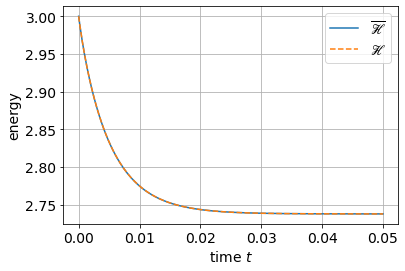

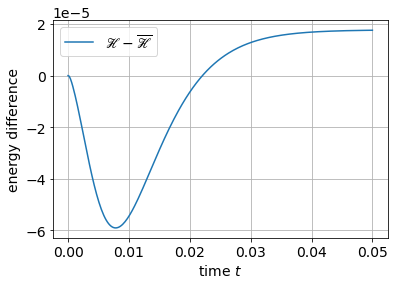

In [82]:
k       = 64
n_steps = 256

mesh,u,it,t      = read_state('output_darcy/stateP1_'+str(k)+'_'+str(n_steps)+'_'+str(0),FE)
meshbar,ubar,_,_ = read_state('output_darcy/statebarP1_'+str(k)+'_'+str(n_steps)+'_'+str(0),FE)
    
tt   = [t]
E    = [assemble(energy(u)*dx)]
Ebar = [assemble(energybar(ubar)*dx)]

for i in range(n_steps):
    mesh,u,it,t      = read_state('output_darcy/stateP1_'+str(k)+'_'+str(n_steps)+'_'+str(i+1),FE)
    meshbar,ubar,_,_ = read_state('output_darcy/statebarP1_'+str(k)+'_'+str(n_steps)+'_'+str(i+1),FE)
    tt.append(t)
    E.append(assemble(energy(u)*dx))
    Ebar.append(assemble(energybar(ubar)*dx))
 
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14}) 

plt.plot(tt,E,label='$\overline{\mathscr{H}}$')
plt.plot(tt,Ebar,'--',label='$\mathscr{H}$')

plt.xlabel('time $t$')
plt.ylabel('energy')
plt.legend()
plt.grid(True)

plt.savefig('media/darcy_energy.pdf',bbox_inches = 'tight')

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14}) 

plt.plot(tt,np.subtract(E,Ebar),label='$\mathscr{H}-\overline{\mathscr{H}}$')

plt.xlabel('time $t$')
plt.ylabel('energy difference')
plt.legend()
plt.grid(True)

plt.savefig('media/darcy_diffenergy.pdf',bbox_inches = 'tight')

# Convergence in space

In [95]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt 

mesh,u,it,t      = read_state('output_darcy/stateP1_'+str(k)+'_'+str(n_steps)+'_'+str(0),FE)
meshbar,ubar,_,_ = read_state('output_darcy/statebarP1_'+str(k)+'_'+str(n_steps)+'_'+str(0),FE)

for rr in range(7):
    n_steps  = 256
    k        = 4*(2**rr)

    t        = 0
    L2_err   = 0.0
    H1_err   = 0.0
    tt       = [t]
    for i in range(n_steps):
        mesh,u,it,t      = read_state('output_darcy/stateP1_'+str(k)+'_'+str(n_steps)+'_'+str(i+1),FE)
        meshbar,ubar,_,_ = read_state('output_darcy/statebarP1_'+str(k)+'_'+str(n_steps)+'_'+str(i+1),FE)
        
        tt.append(t)
        ALE.move(meshbar,ubar)
        
        V   = get_space(mesh,FE)
        bcV = DirichletBC(V,Constant((0, 0)),'on_boundary')
        err = project(u-ubar,V,bcs=bcV,solver_type='cg')
        e1 = assemble(inner(err,err)*dx)
        e2 = assemble(inner(grad(err),grad(err))*dx)
        
        tau = tt[-1] - tt[-2]
        L2_err += e1*tau
        H1_err += (e1+e2)*tau
        
    print(f'# k={k:4} tau={tau:.4e} L2: {sqrt(L2_err):.4e} H1: {sqrt(H1_err):.4e}')    

# k=   4 tau=1.9531e-04 L2: 1.2037e-03 H1: 8.0605e-03
# k=   8 tau=1.9531e-04 L2: 4.1485e-04 H1: 4.5654e-03
# k=  16 tau=1.9531e-04 L2: 1.5872e-04 H1: 2.2791e-03
# k=  32 tau=1.9531e-04 L2: 5.5102e-05 H1: 1.1714e-03
# k=  64 tau=1.9531e-04 L2: 1.7316e-05 H1: 5.4968e-04
# k= 128 tau=1.9531e-04 L2: 7.6953e-06 H1: 2.6339e-04
# k= 256 tau=1.9531e-04 L2: 6.1642e-06 H1: 1.3243e-04


In [96]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt 

for rr in range(7-1):
    n_steps  = 256
    k        = 4*(2**rr)

    t        = 0
    L2_err   = 0.0
    H1_err   = 0.0
    tt       = [t]
    for i in range(n_steps):
        mesh1,u1,it,t = read_state('output_darcy/stateP1_'+str(k  )+'_'+str(n_steps)+'_'+str(i+1),FE)
        mesh2,u2,_,_  = read_state('output_darcy/stateP1_'+str(k*2)+'_'+str(n_steps)+'_'+str(i+1),FE)
        
        tt.append(t)
        
        V   = get_space(mesh2,FE)
        bcV = DirichletBC(V,Constant((0, 0)),'on_boundary')
        
        err = project(u1-u2,V,bcs=bcV,solver_type='cg')
        e1 = assemble(inner(err,err)*dx)
        e2 = assemble(inner(grad(err),grad(err))*dx)
        
        tau = tt[-1] - tt[-2]
        L2_err += e1*tau
        H1_err += (e1+e2)*tau
        
    print(f'# k={k:4} tau={tau:.4e} L2: {sqrt(L2_err):.4e} H1: {sqrt(H1_err):.4e}')    

# k=   4 tau=1.9531e-04 L2: 3.0579e-03 H1: 3.8834e-02
# k=   8 tau=1.9531e-04 L2: 9.7084e-04 H1: 2.2106e-02
# k=  16 tau=1.9531e-04 L2: 2.8016e-04 H1: 1.1779e-02
# k=  32 tau=1.9531e-04 L2: 7.6257e-05 H1: 6.0804e-03
# k=  64 tau=1.9531e-04 L2: 2.0097e-05 H1: 3.0906e-03
# k= 128 tau=1.9531e-04 L2: 5.1972e-06 H1: 1.5592e-03


In [97]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt 

for rr in range(7-1):
    n_steps  = 256
    k        = 4*(2**rr)

    t        = 0
    L2_err   = 0.0
    H1_err   = 0.0
    tt       = [t]
    for i in range(n_steps):
        mesh1,u1,it,t = read_state('output_darcy/statebarP1_'+str(k  )+'_'+str(n_steps)+'_'+str(i+1),FE)
        mesh2,u2,_,_  = read_state('output_darcy/statebarP1_'+str(k*2)+'_'+str(n_steps)+'_'+str(i+1),FE)
        
        tt.append(t)
        
        V   = get_space(mesh2,FE)
        bcV = DirichletBC(V,Constant((0, 0)),'on_boundary')
        
        err = project(u1-u2,V,bcs=bcV,solver_type='cg')
        e1 = assemble(inner(err,err)*dx)
        e2 = assemble(inner(grad(err),grad(err))*dx)
        
        tau = tt[-1] - tt[-2]
        L2_err += e1*tau
        H1_err += (e1+e2)*tau
        
    print(f'# k={k:4} tau={tau:.4e} L2: {sqrt(L2_err):.4e} H1: {sqrt(H1_err):.4e}')    

# k=   4 tau=1.9531e-04 L2: 2.7701e-03 H1: 3.5601e-02
# k=   8 tau=1.9531e-04 L2: 8.8251e-04 H1: 2.0101e-02
# k=  16 tau=1.9531e-04 L2: 2.5589e-04 H1: 1.0673e-02
# k=  32 tau=1.9531e-04 L2: 7.0277e-05 H1: 5.5100e-03
# k=  64 tau=1.9531e-04 L2: 1.8677e-05 H1: 2.8048e-03
# k= 128 tau=1.9531e-04 L2: 4.8582e-06 H1: 1.4169e-03


# Convergence in time

In [100]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt 

for rr in range(7):
    n_steps  = 4 * 2**rr
    k        = 256

    t        = 0
    L2_err   = 0.0
    H1_err   = 0.0
    tt       = [t]
    for i in range(n_steps):
        mesh,u,it,t      = read_state('output_darcy/stateP1_'+str(k)+'_'+str(n_steps)+'_'+str(i+1),FE)
        meshbar,ubar,_,_ = read_state('output_darcy/statebarP1_'+str(k)+'_'+str(n_steps)+'_'+str(i+1),FE)
        
        tt.append(t)
        ALE.move(meshbar,ubar)
        
        V   = get_space(mesh,FE)
        bcV = DirichletBC(V,Constant((0, 0)),'on_boundary')
        err = project(u-ubar,V,bcs=bcV,solver_type='cg')
        e1 = assemble(inner(err,err)*dx)
        e2 = assemble(inner(grad(err),grad(err))*dx)
        
        tau = tt[-1] - tt[-2]
        L2_err += e1*tau
        H1_err += (e1+e2)*tau
    print(f'# k={k:4} tau={tau:.4e} L2: {sqrt(L2_err):.4e} H1: {sqrt(H1_err):.4e}')    

# k= 256 tau=1.2500e-02 L2: 1.6163e-04 H1: 1.2483e-03
# k= 256 tau=6.2500e-03 L2: 1.1631e-04 H1: 8.6811e-04
# k= 256 tau=3.1250e-03 L2: 7.3059e-05 H1: 5.4044e-04
# k= 256 tau=1.5625e-03 L2: 4.1712e-05 H1: 3.2139e-04
# k= 256 tau=7.8125e-04 L2: 2.2493e-05 H1: 2.0186e-04
# k= 256 tau=3.9062e-04 L2: 1.1796e-05 H1: 1.4997e-04
# k= 256 tau=1.9531e-04 L2: 6.1642e-06 H1: 1.3243e-04


In [101]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt 

for rr in range(7-1):
    n_steps  = 4 * 2**rr
    k        = 256

    t        = 0
    L2_err   = 0.0
    H1_err   = 0.0
    tt       = [t]
    
    for i in range(n_steps):
        mesh1,u1,it,t = read_state('output_darcy/stateP1_'+str(k)+'_'+str(n_steps)+'_'+str(i+1),FE)
        mesh2,u2,_,_  = read_state('output_darcy/stateP1_'+str(k)+'_'+str(2*n_steps)+'_'+str(2*(i+1)),FE)
        
        tt.append(t)
        ALE.move(meshbar,ubar)
        
        V   = get_space(mesh1,FE)
        bcV = DirichletBC(V,Constant((0, 0)),'on_boundary')
        err = project(u1-u2,V,bcs=bcV,solver_type='cg')
        e1 = assemble(inner(err,err)*dx)
        e2 = assemble(inner(grad(err),grad(err))*dx)
        
        tau = tt[-1] - tt[-2]
        L2_err += e1*tau
        H1_err += (e1+e2)*tau
        
    print(f'# k={k:4} tau={tau:.4e} L2: {sqrt(L2_err):.4e} H1: {sqrt(H1_err):.4e}')    

# k= 256 tau=1.2500e-02 L2: 1.0415e-03 H1: 5.5101e-03
# k= 256 tau=6.2500e-03 L2: 5.9736e-04 H1: 3.2469e-03
# k= 256 tau=3.1250e-03 L2: 3.2175e-04 H1: 1.8089e-03
# k= 256 tau=1.5625e-03 L2: 1.6778e-04 H1: 9.7408e-04
# k= 256 tau=7.8125e-04 L2: 8.5896e-05 H1: 5.1280e-04
# k= 256 tau=3.9062e-04 L2: 4.3515e-05 H1: 2.6581e-04


In [102]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt 

for rr in range(7-1):
    n_steps  = 4 * 2**rr
    k        = 256

    t        = 0
    L2_err   = 0.0
    H1_err   = 0.0
    tt       = [t]
    
    for i in range(n_steps):
        mesh1,u1,it,t = read_state('output_darcy/statebarP1_'+str(k)+'_'+str(n_steps)+'_'+str(i+1),FE)
        mesh2,u2,_,_  = read_state('output_darcy/statebarP1_'+str(k)+'_'+str(2*n_steps)+'_'+str(2*(i+1)),FE)
        
        tt.append(t)
        
        V   = get_space(mesh1,FE)
        bcV = DirichletBC(V,Constant((0, 0)),'on_boundary')
        err = project(u1-u2,V,bcs=bcV,solver_type='cg')
        e1 = assemble(inner(err,err)*dx)
        e2 = assemble(inner(grad(err),grad(err))*dx)
        
        tau = tt[-1] - tt[-2]
        L2_err += e1*tau
        H1_err += (e1+e2)*tau
        
    print(f'# k={k:4} tau={tau:.4e} L2: {sqrt(L2_err):.4e} H1: {sqrt(H1_err):.4e}')    

# k= 256 tau=1.2500e-02 L2: 1.0269e-03 H1: 4.9682e-03
# k= 256 tau=6.2500e-03 L2: 6.0963e-04 H1: 3.0377e-03
# k= 256 tau=3.1250e-03 L2: 3.3756e-04 H1: 1.7367e-03
# k= 256 tau=1.5625e-03 L2: 1.7910e-04 H1: 9.5020e-04
# k= 256 tau=7.8125e-04 L2: 9.2588e-05 H1: 5.0476e-04
# k= 256 tau=3.9062e-04 L2: 4.7146e-05 H1: 2.6294e-04


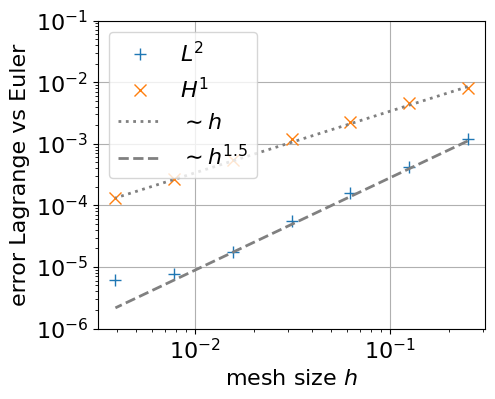

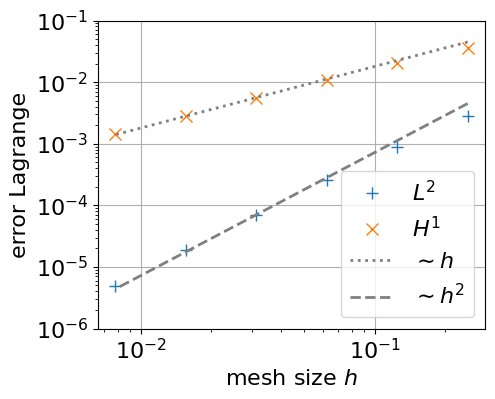

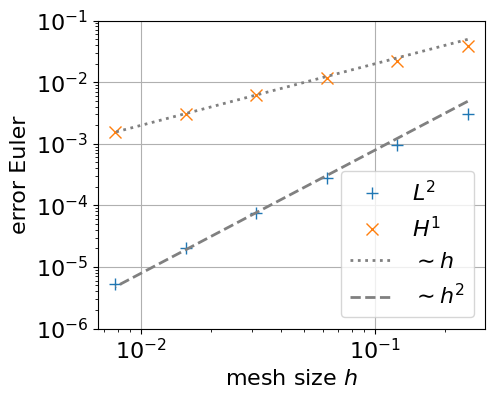

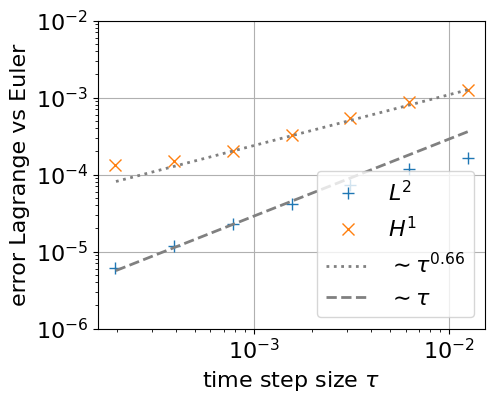

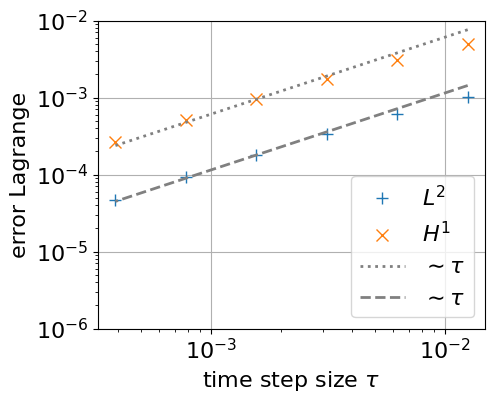

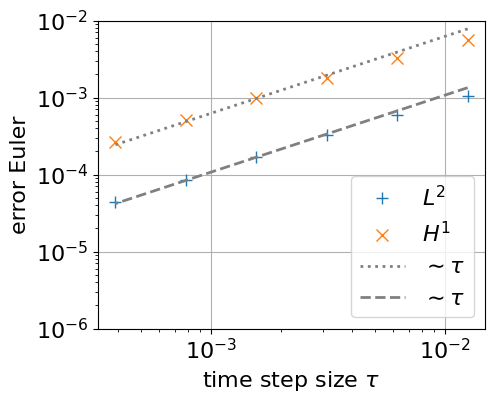

In [159]:
import numpy as np
from pylab import plt

plt.rcParams.update(plt.rcParamsDefault)
#
# SPACE
#
# P1 convergence space: Lagrange vs Euler tau = T/256
# k=   4 tau=1.9531e-04 L2: 1.2037e-03 H1: 8.0605e-03
# k=   8 tau=1.9531e-04 L2: 4.1485e-04 H1: 4.5654e-03
# k=  16 tau=1.9531e-04 L2: 1.5872e-04 H1: 2.2791e-03
# k=  32 tau=1.9531e-04 L2: 5.5102e-05 H1: 1.1714e-03
# k=  64 tau=1.9531e-04 L2: 1.7316e-05 H1: 5.4968e-04
# k= 128 tau=1.9531e-04 L2: 7.6953e-06 H1: 2.6339e-04
# k= 256 tau=1.9531e-04 L2: 6.1642e-06 H1: 1.3243e-04
kk_h_LE = [4,8,16,32,64,128,256]
L2_h_LE = [1.2037e-03,4.1485e-04,1.5872e-04,5.5102e-05,1.7316e-05,7.6953e-06,6.1642e-06]
H1_h_LE = [8.0605e-03,4.5654e-03,2.2791e-03,1.1714e-03,5.4968e-04,2.6339e-04,1.3243e-04]

h_h_LE = np.divide(1,kk_h_LE)

# P1 convergence space: Euler h tau = T/256
# k=   4 tau=1.9531e-04 L2: 3.0579e-03 H1: 3.8834e-02
# k=   8 tau=1.9531e-04 L2: 9.7084e-04 H1: 2.2106e-02
# k=  16 tau=1.9531e-04 L2: 2.8016e-04 H1: 1.1779e-02
# k=  32 tau=1.9531e-04 L2: 7.6257e-05 H1: 6.0804e-03
# k=  64 tau=1.9531e-04 L2: 2.0097e-05 H1: 3.0906e-03
# k= 128 tau=1.9531e-04 L2: 5.1972e-06 H1: 1.5592e-03
kk_h_E = [4,8,16,32,64,128]
L2_h_E = [3.0579e-03,9.7084e-04,2.8016e-04,7.6257e-05,2.0097e-05,5.1972e-06]
H1_h_E = [3.8834e-02,2.2106e-02,1.1779e-02,6.0804e-03,3.0906e-03,1.5592e-03]
h_h_E  = np.divide(1,kk_h_E)

# P1 convergence space: Lagrange h tau = T/256
# k=   4 tau=1.9531e-04 L2: 2.7701e-03 H1: 3.5601e-02
# k=   8 tau=1.9531e-04 L2: 8.8251e-04 H1: 2.0101e-02
# k=  16 tau=1.9531e-04 L2: 2.5589e-04 H1: 1.0673e-02
# k=  32 tau=1.9531e-04 L2: 7.0277e-05 H1: 5.5100e-03
# k=  64 tau=1.9531e-04 L2: 1.8677e-05 H1: 2.8048e-03
# k= 128 tau=1.9531e-04 L2: 4.8582e-06 H1: 1.4169e-03
kk_h_L = [4,8,16,32,64,128]
L2_h_L = [2.7701e-03,8.8251e-04,2.5589e-04,7.0277e-05,1.8677e-05,4.8582e-06]
H1_h_L = [3.5601e-02,2.0101e-02,1.0673e-02,5.5100e-03,2.8048e-03,1.4169e-03]
h_h_L  = np.divide(1,kk_h_L)
#
# TIME
#
# P1 convergence time: Lagrange vs Euler h=1/256
# k= 256 tau=1.2500e-02 L2: 1.6163e-04 H1: 1.2483e-03
# k= 256 tau=6.2500e-03 L2: 1.1631e-04 H1: 8.6811e-04
# k= 256 tau=3.1250e-03 L2: 7.3059e-05 H1: 5.4044e-04
# k= 256 tau=1.5625e-03 L2: 4.1712e-05 H1: 3.2139e-04
# k= 256 tau=7.8125e-04 L2: 2.2493e-05 H1: 2.0186e-04
# k= 256 tau=3.9062e-04 L2: 1.1796e-05 H1: 1.4997e-04
# k= 256 tau=1.9531e-04 L2: 6.1642e-06 H1: 1.3243e-04
tt_t_LE = [1.2500e-02,6.2500e-03,3.1250e-03,1.5625e-03,7.8125e-04,3.9062e-04,1.9531e-04]
L2_t_LE = [1.6163e-04,1.1631e-04,7.3059e-05,4.1712e-05,2.2493e-05,1.1796e-05,6.1642e-06]
H1_t_LE = [1.2483e-03,8.6811e-04,5.4044e-04,3.2139e-04,2.0186e-04,1.4997e-04,1.3243e-04]

# P1 convergence time: Euler h=1/256
# k= 256 tau=1.2500e-02 L2: 1.0415e-03 H1: 5.5101e-03
# k= 256 tau=6.2500e-03 L2: 5.9736e-04 H1: 3.2469e-03
# k= 256 tau=3.1250e-03 L2: 3.2175e-04 H1: 1.8089e-03
# k= 256 tau=1.5625e-03 L2: 1.6778e-04 H1: 9.7408e-04
# k= 256 tau=7.8125e-04 L2: 8.5896e-05 H1: 5.1280e-04
# k= 256 tau=3.9062e-04 L2: 4.3515e-05 H1: 2.6581e-04
tt_t_E = [1.2500e-02,6.2500e-03,3.1250e-03,1.5625e-03,7.8125e-04,3.9062e-04]
L2_t_E = [1.0415e-03,5.9736e-04,3.2175e-04,1.6778e-04,8.5896e-05,4.3515e-05]
H1_t_E = [5.5101e-03,3.2469e-03,1.8089e-03,9.7408e-04,5.1280e-04,2.6581e-04]

# P1 convergence time: Lagrange h=1/256
# k= 256 tau=1.2500e-02 L2: 1.0269e-03 H1: 4.9682e-03
# k= 256 tau=6.2500e-03 L2: 6.0963e-04 H1: 3.0377e-03
# k= 256 tau=3.1250e-03 L2: 3.3756e-04 H1: 1.7367e-03
# k= 256 tau=1.5625e-03 L2: 1.7910e-04 H1: 9.5020e-04
# k= 256 tau=7.8125e-04 L2: 9.2588e-05 H1: 5.0476e-04
# k= 256 tau=3.9062e-04 L2: 4.7146e-05 H1: 2.6294e-04
tt_t_L = [1.2500e-02,6.2500e-03,3.1250e-03,1.5625e-03,7.8125e-04,3.9062e-04]
L2_t_L = [1.0269e-03,6.0963e-04,3.3756e-04,1.7910e-04,9.2588e-05,4.7146e-05]
H1_t_L = [4.9682e-03,3.0377e-03,1.7367e-03,9.5020e-04,5.0476e-04,2.6294e-04]

sx=5.0
sy=4.0
fs=16

########################################################
# space: Lagrangian -- Eulerian error
plt.figure(figsize=(sx,sy))
plt.rcParams.update({'font.size': fs})

h = h_h_LE
plt.loglog(h,L2_h_LE,'+',label='$X=L^2$',markersize=8)
plt.loglog(h,H1_h_LE,'x',label='$X=H^1$',markersize=8)

L2scal = L2_h_LE[-3]/h[-3]**1.5
H1scal = H1_h_LE[-2]/h[-2]

plt.plot(h,np.multiply(np.power(h,1),H1scal),':',color=[0.5,0.5,0.5],label='$\sim h$',linewidth=2)
plt.plot(h,np.multiply(np.power(h,1.5),L2scal),'--',color=[0.5,0.5,0.5],label='$\sim h^{1.5}$',linewidth=2)

plt.ylim([1e-6,1e-1])
plt.legend()

plt.xlabel('mesh size $h$')
plt.ylabel('error Lagrange vs Euler')
plt.grid(True)
plt.savefig('media/darcy_h_LE.pdf',bbox_inches = 'tight')

########################################################
# space: Lagrangian error
plt.figure(figsize=(sx,sy))
plt.rcParams.update({'font.size': fs})

h = h_h_L
plt.loglog(h,L2_h_L,'+',label='$X=L^2$',markersize=8)
plt.loglog(h,H1_h_L,'x',label='$X=H^1$',markersize=8)

L2scal = L2_h_L[-3]/h[-3]**2
H1scal = H1_h_L[-2]/h[-2]

plt.plot(h,np.multiply(np.power(h,1),H1scal),':',color=[0.5,0.5,0.5],label='$\sim h$',linewidth=2)
plt.plot(h,np.multiply(np.power(h,2),L2scal),'--',color=[0.5,0.5,0.5],label='$\sim h^{2}$',linewidth=2)

plt.ylim([1e-6,1e-1])
plt.legend()

plt.xlabel('mesh size $h$')
plt.ylabel('error Lagrange')
plt.grid(True)
plt.savefig('media/darcy_h_L.pdf',bbox_inches = 'tight')

########################################################
# space: Eulerian error
plt.figure(figsize=(sx,sy))
plt.rcParams.update({'font.size': fs})

h = h_h_E
plt.loglog(h,L2_h_E,'+',label='$X=L^2$',markersize=8)
plt.loglog(h,H1_h_E,'x',label='$X=H^1$',markersize=8)

L2scal = L2_h_E[-3]/h[-3]**2
H1scal = H1_h_E[-2]/h[-2]

plt.plot(h,np.multiply(np.power(h,1),H1scal),':',color=[0.5,0.5,0.5],label='$\sim h$',linewidth=2)
plt.plot(h,np.multiply(np.power(h,2),L2scal),'--',color=[0.5,0.5,0.5],label='$\sim h^{2}$',linewidth=2)

plt.ylim([1e-6,1e-1])
plt.legend()

plt.xlabel('mesh size $h$')
plt.ylabel('error Euler')
plt.grid(True)
plt.savefig('media/darcy_h_E.pdf',bbox_inches = 'tight')

########################################################
# time: Lagrangian -- Eulerian error
plt.figure(figsize=(sx,sy))
plt.rcParams.update({'font.size': fs})

tau = tt_t_LE
plt.loglog(tau,L2_t_LE,'+',label='$X=L^2$',markersize=8)
plt.loglog(tau,H1_t_LE,'x',label='$X=H^1$',markersize=8)

L2scal = L2_t_LE[-3]/tau[-3]
H1scal = H1_t_LE[-3]/tau[-3]**0.66

plt.plot(tau,np.multiply(np.power(tau,0.66),H1scal),':',color=[0.5,0.5,0.5],label=r'$\sim \tau^{0.66}$',linewidth=2)
plt.plot(tau,np.multiply(np.power(tau,1),L2scal),'--',color=[0.5,0.5,0.5],label=r'$\sim \tau$',linewidth=2)

plt.ylim([1e-6,1e-2])
plt.legend()

plt.xlabel(r'time step size $\tau$')
plt.ylabel('error Lagrange vs Euler')
plt.grid(True)
plt.savefig('media/darcy_tau_LE.pdf',bbox_inches = 'tight')


########################################################
# time: Lagrangian error
plt.figure(figsize=(sx,sy))
plt.rcParams.update({'font.size': fs})

tau = tt_t_L
plt.loglog(tau,L2_t_L,'+',label='$X=L^2$',markersize=8)
plt.loglog(tau,H1_t_L,'x',label='$X=H^1$',markersize=8)

L2scal = L2_t_L[-3]/tau[-3]
H1scal = H1_t_L[-3]/tau[-3]

plt.plot(tau,np.multiply(np.power(tau,1),H1scal),':',color=[0.5,0.5,0.5],label=r'$\sim \tau$',linewidth=2)
plt.plot(tau,np.multiply(np.power(tau,1),L2scal),'--',color=[0.5,0.5,0.5],label=r'$\sim \tau$',linewidth=2)

plt.ylim([1e-6,1e-2])
plt.legend()

plt.xlabel(r'time step size $\tau$')
plt.ylabel('error Lagrange')
plt.grid(True)
plt.savefig('media/darcy_tau_L.pdf',bbox_inches = 'tight')

########################################################
# time: Lagrangian error
plt.figure(figsize=(sx,sy))
plt.rcParams.update({'font.size': fs})

tau = tt_t_E
plt.loglog(tau,L2_t_E,'+',label='$X=L^2$',markersize=8)
plt.loglog(tau,H1_t_E,'x',label='$X=H^1$',markersize=8)

L2scal = L2_t_E[-3]/tau[-3]
H1scal = H1_t_E[-3]/tau[-3]

plt.plot(tau,np.multiply(np.power(tau,1),H1scal),':',color=[0.5,0.5,0.5],label=r'$\sim \tau$',linewidth=2)
plt.plot(tau,np.multiply(np.power(tau,1),L2scal),'--',color=[0.5,0.5,0.5],label=r'$\sim \tau$',linewidth=2)

plt.ylim([1e-6,1e-2])
plt.legend()

plt.xlabel(r'time step size $\tau$')
plt.ylabel('error Euler')
plt.grid(True)
plt.savefig('media/darcy_tau_E.pdf',bbox_inches = 'tight')